<a href="https://colab.research.google.com/github/henrycgbaker/nlp_research_note/blob/main/research_note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import kagglehub
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import spacy
import spacy.cli
from sklearn.feature_extraction.text import CountVectorizer
import fasttext.util as fasttext_util
import fasttext
from sklearn.metrics import f1_score
from collections import Counter
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import tqdm
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate
from sklearn.metrics import f1_score, accuracy_score
import warnings
import sys
from sklearn.metrics import f1_score
from tqdm import tqdm

warnings.filterwarnings("ignore")

/Users/henrybaker/miniconda3/envs/nlp_1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hertie server
'''
import os
# Set the environment variables
os.environ['HOME_CONFIG'] = './/workspace/workspace'
os.environ['KAGGLE_CONFIG'] = './workspace/workspace/.kaggle'
os.environ['SPACY_CACHE'] = '/workspace/workspace/cache'

# Optionally, check if the environment variables were set correctly
print(os.getenv('HOME_CONFIG'))
print(os.getenv('KAGGLE_CONFIG'))
print(os.getenv('SPACY_CACHE'))
'''

"\nimport os\n# Set the environment variables\nos.environ['HOME_CONFIG'] = './/workspace/workspace'\nos.environ['KAGGLE_CONFIG'] = './workspace/workspace/.kaggle'\nos.environ['SPACY_CACHE'] = '/workspace/workspace/cache'\n\n# Optionally, check if the environment variables were set correctly\nprint(os.getenv('HOME_CONFIG'))\nprint(os.getenv('KAGGLE_CONFIG'))\nprint(os.getenv('SPACY_CACHE'))\n"

In [3]:

# download pretrained embeddings -----------------------------------------------
# for local
#fasttext.util.download_model('en', if_exists='ignore')
ft_path = "./cc.en.300.bin"

# for Colab
# !pip install datasets fasttext evaluate
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir('/content/drive/Othercomputers/My MacBook Pro/Documents/repositories/nlp/nlp_research_note')
#ft_path = "./cc.en.300.bin"

ft = fasttext.load_model(ft_path)

# download spacy model for tokenization ----------------------------------------
cache_path = './cache/'
os.makedirs(cache_path, exist_ok=True)
os.environ['SPACY_DATA'] = cache_path
spacy.cli.download("en_core_web_sm")

# load helper functions & scripts ----------------------------------------------
'''
sys.path.append('./aux_scripts')
from  misinfo_tokenizer import (get_trained_tokenizer,
                                batch_tokenize,
                                #vocab_mapping,
                                custom_analyzer
                                )
from data_loader_helpers import (#Collator,
                                 embedding_mapping_fasttext
                                 )
'''

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.9 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


"\nsys.path.append('./aux_scripts')\nfrom  misinfo_tokenizer import (get_trained_tokenizer,\n                                batch_tokenize,\n                                #vocab_mapping,\n                                custom_analyzer\n                                )\nfrom data_loader_helpers import (#Collator,\n                                 embedding_mapping_fasttext\n                                 )\n"

---
# Import & process Hugging Face `misinfo` dataset

In [4]:
hf_cache_dir = os.getenv("HF_DATASETS_CACHE", "./cache/huggingface/datasets")
dataset_path = os.path.join(hf_cache_dir, "roupenminassian", "twitter-misinformation")

if os.path.exists(dataset_path):
    print(f"Dataset found in cache: {dataset_path}")
    ds = load_dataset("roupenminassian/twitter-misinformation", cache_dir=hf_cache_dir)
else:
    print(f"Dataset not found in cache. Downloading...")
    ds = load_dataset("roupenminassian/twitter-misinformation")

print(f'Cache Directory: \n{hf_cache_dir}')
print(f'\nExternal Structure: \n{ds.shape}')
print(f'\nInternal Structure: \n{ds["train"]}')

Dataset not found in cache. Downloading...
Cache Directory: 
./cache/huggingface/datasets

External Structure: 
{'train': (92394, 4), 'test': (10267, 4)}

Internal Structure: 
Dataset({
    features: ['Unnamed: 0.1', 'Unnamed: 0', 'text', 'label'],
    num_rows: 92394
})


In [5]:
# DATA PARTITIONING =====================================================================
ds_cloned = ds.copy()

ds_cloned['train'] = ds_cloned['train'].remove_columns(['Unnamed: 0', 'Unnamed: 0.1'])
ds_cloned['test'] = ds_cloned['test'].remove_columns(['Unnamed: 0', 'Unnamed: 0.1'])

df_misinfo_train = pd.DataFrame(ds_cloned['train'], columns=["text", "label"])
df_misinfo_test = pd.DataFrame(ds_cloned['test'], columns=["text", "label"])

df_misinfo_train = df_misinfo_train.sample(n=5000, random_state=42) # REMOVE THIS
df_misinfo_test = df_misinfo_test.sample(n=5000, random_state=42) # REMOVE THIS

print(f"Train shape {df_misinfo_train.shape} \n")
print('\n0: factual, 1: misinformation\n')
print("Training positive vs negative examples: \n", df_misinfo_train.value_counts("label")/df_misinfo_train.shape[0])
print("\nTesting positive vs negative examples: \n",df_misinfo_test.value_counts("label")/df_misinfo_test.shape[0])

df_misinfo_train.head()

Train shape (5000, 2) 


0: factual, 1: misinformation

Training positive vs negative examples: 
 label
0    0.646
1    0.354
Name: count, dtype: float64

Testing positive vs negative examples: 
 label
0    0.6548
1    0.3452
Name: count, dtype: float64


,text,label
62905,"A sudden there was a flood on the road, and th...",0
48977,"No food, no FEMA: Hurricane Michael’s survivor...",0
20691,"President Trump visits Florida hospital, prai...",1
32672,"During my 2nd week at @sacbee_news, I covered ...",0
70612,"Irma is a 5 category hurricane, and your prior...",0


In [6]:
# DEFINE TOKENIZATION FLOW =====================================================================

nlp = spacy.load("en_core_web_sm", 
                 disable=["tok2vec", "tagger", "parser", "ner", "lemmatizer", "attribute_ruler"])

def custom_tokenizer(text):
    tokenized_text = nlp(text)
    return [tok.text for tok in tokenized_text]

def custom_analyzer(text, trained_tokenizer):
    """
    Uses the custom_tokenizer, then replaces out-of-vocabulary tokens with <unk>.
    """
    tokens = custom_tokenizer(text)
    vocab = trained_tokenizer.vocabulary_
    return [token if token in vocab else "<unk>" for token in tokens]

def get_trained_tokenizer(text_series, tokenizer_file=None, min_df=3):
    """
    1) Checks if a previously fitted tokenizer exists in tokenizer_file.
    2) If not, create a new CountVectorizer, fit it on 'text_series'.
    3) Save the fitted tokenizer if tokenizer_file is provided.
    4) Return the tokenizer.
    """
    # If a tokenizer file path is given and exists, load it
    if tokenizer_file and os.path.exists(tokenizer_file):
        print(f"Tokenizer file '{tokenizer_file}' found. Loading it...")
        with open(tokenizer_file, 'rb') as f:
            tokenizer = pickle.load(f)
    else:
        # Otherwise, create a new one and fit
        print("No pre-fitted tokenizer found or no file specified. Creating a new one...")
        tokenizer = CountVectorizer(
            analyzer="word",
            tokenizer=custom_tokenizer,  # We define custom_tokenizer for splitting
            lowercase=False,
            min_df=min_df
        )
        tokenizer.fit(text_series)
        
        # Save the tokenizer if a path was provided
        if tokenizer_file:
            print(f"Saving fitted tokenizer to '{tokenizer_file}'...")
            with open(tokenizer_file, 'wb') as f:
                pickle.dump(tokenizer, f)

    return tokenizer

def batch_tokenize(text_series, batch_size, analyzer_func):
    """
    Tokenizes a Pandas Series of text in batches to avoid memory issues.
    """
    tokenized_result = []
    total = len(text_series)
    num_batches = (total // batch_size) + (1 if total % batch_size != 0 else 0)
    
    for batch_idx in range(0, total, batch_size):
        
        # Print progress every 200 batches or at the last batch
        if (batch_idx // batch_size + 1) % 200 == 0 or (batch_idx + batch_size >= total):
            print(f'Tokenizing batch {batch_idx // batch_size + 1} of {num_batches}...')
        
        batch_texts = text_series[batch_idx : batch_idx + batch_size]
        for text in batch_texts:
            tokenized_result.append(analyzer_func(text))
    
    return tokenized_result

# TOKENIZATION ==========================================================================

TOKENIZER_DIR = './cache/misinfo_tokenizer.pkl'
TRAIN_TOKENISED_DIR = './cache/misinfo_train_tokenised.pkl'
TEST_TOKENISED_DIR = './cache/misinfo_test_tokenised.pkl'

if os.path.exists(TRAIN_TOKENISED_DIR) and os.path.exists(TEST_TOKENISED_DIR):
    print("Tokenized text pkl files found: loading data...")
    # Load pre-saved tokenized data
    with open(TRAIN_TOKENISED_DIR, 'rb') as f:
        misinfo_train_tokenised = pickle.load(f)
    with open(TEST_TOKENISED_DIR, 'rb') as f:
        misinfo_test_tokenised = pickle.load(f)

else:
    print("Pickle files not found. Running tokenization...")

    # 1) Train tokenizer
    misinfo_tokenizer = get_trained_tokenizer(
        df_misinfo_train["text"],
        tokenizer_file=TOKENIZER_DIR,
        min_df=3
    )

    # Build the default analyzer from our tokenizer
    misinfo_tokenizer_analyzer = misinfo_tokenizer.build_analyzer()

    # 2) Tokenize train data in batches using the built analyzer (trained on train set)
    print("Tokenizing Train Data in Batches...")
    misinfo_train_tokenised = batch_tokenize(
        df_misinfo_train["text"],
        32,
        misinfo_tokenizer_analyzer
    )
    
    # 3) Tokenize test data in batches using custom_analyzer (which replaces OOV tokens with <unk>)
    print("Tokenizing Test Data in Batches...")
    misinfo_test_tokenised = batch_tokenize(
        df_misinfo_test["text"],
        32,
        lambda text: custom_analyzer(text, trained_tokenizer=misinfo_tokenizer)
    )

    # Optionally, save the tokenized data
    with open(TRAIN_TOKENISED_DIR, 'wb') as f:
        pickle.dump(misinfo_train_tokenised, f)
    with open(TEST_TOKENISED_DIR, 'wb') as f:
        pickle.dump(misinfo_test_tokenised, f)

print("Train inputs tokenised:", len(misinfo_train_tokenised))
print("Test inputs tokenised:", len(misinfo_test_tokenised))

Pickle files not found. Running tokenization...
No pre-fitted tokenizer found or no file specified. Creating a new one...
Saving fitted tokenizer to './cache/misinfo_tokenizer.pkl'...
Tokenizing Train Data in Batches...
Tokenizing batch 157 of 157...
Tokenizing Test Data in Batches...
Tokenizing batch 157 of 157...
Train inputs tokenised: 5000
Test inputs tokenised: 5000


In [7]:
# STEP 1: INPUT PIPELINE ================================================================

# vocabulary indexing -------------------------------------------------------------------

def vocab_mapping(tokenized_text):
    token_counts = Counter()
    for text in tokenized_text:
        token_counts.update(text)
    special_tokens = ["<pad>", "<unk>"]
    vocab_tokens = special_tokens + [token for token, freq in token_counts.most_common()]
    vocab = {token: idx for idx, token in enumerate(vocab_tokens)}
    return vocab

vocab_idx = vocab_mapping(tokenized_text=misinfo_train_tokenised)

print(f"Vocab size: {len(vocab_idx)}")
print(f"Vocab example: {list(vocab_idx.items())[:10]}")

Vocab size: 46425
Vocab example: [('<pad>', 0), ('<unk>', 1), ('the', 2), (',', 3), ('.', 4), ('to', 5), ('of', 6), ('and', 7), ('a', 8), ('in', 9)]


In [32]:
# create data loaders -------------------------------------------------------------------

def collate_fn(data, include_lengths=True):
    text_list, label_list, lengths = [], [], []
    for _text, _label in data:
        # Integer encoding with truncation
        processed_text = torch.tensor([vocab_idx[token] for token in _text][:max_seq_length],
                                      dtype=torch.int64)
        text_list.append(processed_text)
        label_list.append(_label)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    # Padding
    padded_text_list = nn.utils.rnn.pad_sequence(text_list,
                                                 batch_first=True,
                                                 padding_value=0)
    if include_lengths:
        return padded_text_list, label_list, lengths
    else:
        return padded_text_list, label_list

max_seq_length = 300 # too long for classic RNN
batch_size = 32

# standard dls with collate_fn
train_dl = DataLoader(dataset=list(zip(misinfo_train_tokenised,
                                         df_misinfo_train["label"])),
                        batch_size=32, shuffle=True, 
                        collate_fn=lambda x: collate_fn(x, include_lengths=True))

test_dl = DataLoader(dataset=list(zip(misinfo_test_tokenised,
                                         df_misinfo_test["label"])),
                        batch_size=32, shuffle=False, 
                        collate_fn=lambda x: collate_fn(x, include_lengths=True))

# dls w/o collate_fn for CNNs:
train_dl_cnn = DataLoader(dataset=list(zip(misinfo_train_tokenised,
                                         df_misinfo_train["label"])),
                        batch_size=32, shuffle=True,
                        collate_fn=lambda x: collate_fn(x, include_lengths=False))

test_dl_cnn = DataLoader(dataset=list(zip(misinfo_test_tokenised,
                                         df_misinfo_test["label"])),
                         batch_size=32, shuffle=True,
                        collate_fn=lambda x: collate_fn(x, include_lengths=False))

In [9]:
# EMBEDDING MAPPING =====================================================================

# map pretrained fasttext embeddings to vocabulary indices ------------------------------

EMBEDDINGS_FILE_PATH = "./cache/mapped_pretrained_embeddings.pkl"

def embedding_mapping_fasttext(vocabulary, pre_trained_embeddings):
    vocab_size = len(vocabulary)
    embedding_dim = pre_trained_embeddings.get_dimension()
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for idx, word in enumerate(vocabulary):
        embedding_matrix[idx] = pre_trained_embeddings.get_word_vector(word)
    return embedding_matrix

if os.path.exists(EMBEDDINGS_FILE_PATH):
    with open(EMBEDDINGS_FILE_PATH, 'rb') as f:
        embedding_tensor = pickle.load(f)
    print(f"Emebddings pre-exists: loaded embeddings from {EMBEDDINGS_FILE_PATH}. Shape: {embedding_tensor.shape}")
else:
    print("Embeddings do not pre-exist: mapping pretrained fasttext embeddings to vocabulary indices")

    mapped_pretrained_embeddings = embedding_mapping_fasttext(vocabulary=vocab_idx,
                                                              pre_trained_embeddings=ft)
    embedding_tensor = torch.FloatTensor(mapped_pretrained_embeddings)

    # Save embeddings
    with open(EMBEDDINGS_FILE_PATH, 'wb') as f:
        pickle.dump(embedding_tensor, f)
    print(f"Saved embeddings to {EMBEDDINGS_FILE_PATH}. Shape: {embedding_tensor.shape}")


Embeddings do not pre-exist: mapping pretrained fasttext embeddings to vocabulary indices
Saved embeddings to ./cache/mapped_pretrained_embeddings.pkl. Shape: torch.Size([46425, 300])


In [41]:
def train(model, num_epochs, train_dl, test_dl, use_lengths=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCEWithLogitsLoss()

    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model.to(device)

    metrics = {
        "loss_train": [],
        "loss_test": [],
        "accuracy_train": [],
        "accuracy_test": [],
        "f1_train": [],
        "f1_test": []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0, 0
        all_train_preds, all_train_labels = [], []

        print(f"Epoch {epoch + 1}/{num_epochs} Training...")
        for batch in tqdm(train_dl, desc="Training", leave=False):
            if use_lengths:
                x_batch, y_batch, lengths = batch
                x_batch, y_batch, lengths = x_batch.to(device), y_batch.to(device), lengths.to(device)
                pred = model(x_batch, lengths)[:, 0]  # Include lengths for RNNs/LSTMs
            else:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)[:, 0]

            # Compute loss
            loss = loss_fn(pred, y_batch.float())

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Metrics
            train_loss += loss.item() * y_batch.size(0)
            preds = (pred >= 0.5).float()
            train_correct += (preds == y_batch).float().sum().item()
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(y_batch.cpu().numpy())

        metrics["loss_train"].append(train_loss / len(train_dl.dataset))
        metrics["accuracy_train"].append(train_correct / len(train_dl.dataset))
        metrics["f1_train"].append(f1_score(all_train_labels, all_train_preds))

        # Evaluation phase
        model.eval()
        test_loss, test_correct = 0, 0
        all_test_preds, all_test_labels = [], []
        print(f"Epoch {epoch + 1}/{num_epochs} Evaluating...")
        with torch.no_grad():
            for batch in tqdm(test_dl, desc="Evaluating", leave=False):
                if use_lengths:
                    x_batch, y_batch, lengths = batch
                    x_batch, y_batch, lengths = x_batch.to(device), y_batch.to(device), lengths.to(device)
                    pred = model(x_batch, lengths)[:, 0]
                else:
                    x_batch, y_batch = batch
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    pred = model(x_batch)[:, 0]

                # Compute loss
                loss = loss_fn(pred, y_batch.float())

                # Metrics
                test_loss += loss.item() * y_batch.size(0)
                preds = (pred >= 0.5).float()
                test_correct += (preds == y_batch).float().sum().item()
                all_test_preds.extend(preds.cpu().numpy())
                all_test_labels.extend(y_batch.cpu().numpy())

        metrics["loss_test"].append(test_loss / len(test_dl.dataset))
        metrics["accuracy_test"].append(test_correct / len(test_dl.dataset))
        metrics["f1_test"].append(f1_score(all_test_labels, all_test_preds))

        # Print summary
        print(f"Epoch {epoch + 1}/{num_epochs} Summary:")
        print(f"    Train - Loss: {metrics['loss_train'][-1]:.4f}, Accuracy: {metrics['accuracy_train'][-1]:.3f}, F1: {metrics['f1_train'][-1]:.3f}")
        print(f"    Test  - Loss: {metrics['loss_test'][-1]:.4f}, Accuracy: {metrics['accuracy_test'][-1]:.3f}, F1: {metrics['f1_test'][-1]:.3f}")

    return metrics

In [ ]:
# MODEL BUILDING ================================================================

# CNN-based text classification model

class TextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layers
        convolution_layer = nn.Conv1d(in_channels=embedding_tensor.size(1),
                                      out_channels=128,
                                      kernel_size=3,
                                      padding="same")
        activation_layer = nn.ReLU()
        pooling_layer = nn.AdaptiveAvgPool1d(1)
        h_layers = [convolution_layer, activation_layer, pooling_layer]
        self.hidden_layers = nn.ModuleList(h_layers)
        # classification layer
        self.classification_layer = nn.Linear(in_features=128, out_features=1)

    # define forward pass
    def forward(self, x):
        x = self.embedding_layer(x).permute(0, 2, 1)

        for layer in self.hidden_layers:
            x = layer(x)

        x = x.squeeze(2)

        x = self.classification_layer(x)
        return x

model_cnn = TextClassificationModel(embedding_tensor=embedding_tensor)

In [47]:
# Train the model
num_epochs = 10

hist_cnn = train(model_cnn, num_epochs, train_dl_cnn, test_dl_cnn, use_lengths=False)

with open("./models/train_hist/cnn_hist.pkl", "wb") as f:
    pickle.dump(hist_cnn, f)
    
torch.save(model_cnn, "./models/cnn_model.pth")

Using device: mps
Epoch 1/10 Training...


Epoch 1/10 Evaluating...


KeyboardInterrupt: 

In [34]:
# EXTENSION 1: RNN =====================================================================

class RNNTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.rnn_layer = nn.RNN(input_size=embedding_tensor.size(1),
                                hidden_size=32,
                                num_layers=1, # increase to stack RNNs
                                batch_first=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t, h_t = self.rnn_layer(x) # o_t includes the outputs,
                                     # h_t the hidden state at the last time step
        x = h_t[-1, :, :] # extract from last layer (in case of num_layers > 1)
        x = self.classification_layer(x)
        return x

model_rnn = RNNTextClassificationModel(embedding_tensor=embedding_tensor)
hist_rnn = train(model_rnn, num_epochs, train_dl, test_dl, use_lengths=True) # fluctuating f1 scores, exploding gradients

with open("./models/train_hist/rnn_hist.pkl", "wb") as f:
    pickle.dump(hist_rnn, f)

torch.save(model_rnn, "./models/rnn_model.pth")

Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.5884, Accuracy: 0.666, F1: 0.168
    Test  - Loss: 0.5511, Accuracy: 0.746, F1: 0.617
Epoch 2/10 Training...


KeyboardInterrupt: 

In [35]:
# EXTENSION 2: LSTM =====================================================================

class LSTMTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.lstm_layer = nn.LSTM(input_size=embedding_tensor.size(1),
                                  hidden_size=32,
                                  num_layers=1,
                                  batch_first=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t, (h_t, c_t) = self.lstm_layer(x) # c_t the cell state at the last time step
        x = h_t[-1, :, :] # extract from last layer (in case of num_layers > 1)
        x = self.classification_layer(x)
        return x

model_lstm = LSTMTextClassificationModel(embedding_tensor=embedding_tensor)

hist_lstm = train(model_lstm, num_epochs=10, train_dl=train_dl, test_dl=test_dl, use_lengths=True)

with open("./models/train_hist/lstm_hist.pkl", "wb") as f:
    pickle.dump(hist_lstm, f)
    
torch.save(model_lstm, "./models/lstm_model.pth")

Epoch 1/10 Training...


KeyboardInterrupt: 

In [ ]:
# EXTENSION 2.5: STACKING LSTM LAYERS WITH DIFFERENT HIDDEN SIZES =========================

class StackedLSTMTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.lstm_layer_1 = nn.LSTM(input_size=embedding_tensor.size(1),
                                    hidden_size=64,
                                    num_layers=1,
                                    batch_first=True)
        self.lstm_layer_2 = nn.LSTM(input_size=64,
                                    hidden_size=32,
                                    num_layers=1,
                                    batch_first=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t_1, (h_t_1, c_t_1) = self.lstm_layer_1(x)
        o_t_2, (h_t_2, c_t_2) = self.lstm_layer_2(o_t_1)
        x = h_t_2[-1, :, :]
        x = self.classification_layer(x)
        return x

model_lstm_stacked = StackedLSTMTextClassificationModel(embedding_tensor=embedding_tensor)
hist_lstm_stacked = train(model_lstm_stacked, num_epochs, train_dl, test_dl, use_lengths=True)

with open("./models/train_hist/lstm_stacked_hist.pkl", "wb") as f:
    pickle.dump(hist_lstm_stacked, f)

torch.save(model_lstm_stacked, "./models/lstm_stacked_model.pth")

Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.6151, Accuracy: 0.646, F1: 0.001
    Test  - Loss: 0.5594, Accuracy: 0.655, F1: 0.000
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.5095, Accuracy: 0.699, F1: 0.350
    Test  - Loss: 0.4939, Accuracy: 0.717, F1: 0.372
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.4619, Accuracy: 0.739, F1: 0.528
    Test  - Loss: 0.4533, Accuracy: 0.755, F1: 0.536
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.4459, Accuracy: 0.767, F1: 0.580
    Test  - Loss: 0.6065, Accuracy: 0.685, F1: 0.172
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.4907, Accuracy: 0.731, F1: 0.458
    Test  - Loss: 0.4248, Accuracy: 0.805, F1: 0.727
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.3840, Accuracy: 0.816, F1: 0.721
    Test  - Loss: 0.3956, Accuracy: 0.821, F1: 0.755
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.3288, Accuracy: 0.853, F1: 0.776
    Test  - Loss: 0.3073, Accuracy: 0.870, F1: 0.799
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.3954, Accuracy: 0.796, F1: 0.681
    Test  - Loss: 0.3181, Accuracy: 0.861, F1: 0.792
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.3182, Accuracy: 0.867, F1: 0.810
    Test  - Loss: 0.4231, Accuracy: 0.796, F1: 0.737
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.2768, Accuracy: 0.877, F1: 0.812
    Test  - Loss: 0.3157, Accuracy: 0.832, F1: 0.694


In [16]:
# EXTENSION 4: BI-DIRECTIONAL LSTM ======================================================

class BidirectionalLSTMTextClassificationModel(nn.Module):
    # create layers
    def __init__(self, embedding_tensor):
        super().__init__()
        # input layer
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_tensor, freeze=True)
        # hidden layer
        self.bid_lstm_layer = nn.LSTM(input_size=embedding_tensor.size(1),
                                      hidden_size=32,
                                      num_layers=1,
                                      batch_first=True,
                                      bidirectional=True)
        # classification layer
        self.classification_layer = nn.Linear(in_features=32*2, out_features=1)

    # define forward pass
    def forward(self, x, lengths):
        x = self.embedding_layer(x)
        x = nn.utils.rnn.pack_padded_sequence(x,
                                              lengths.cpu().numpy(),
                                              enforce_sorted=False,
                                              batch_first=True)
        o_t, (h_t, c_t) = self.bid_lstm_layer(x)
        x = torch.cat((h_t[-2, :, :],
                       h_t[-1, :, :]), dim=1)
        x = self.classification_layer(x)
        return x

model_bi_lstm = BidirectionalLSTMTextClassificationModel(embedding_tensor=embedding_tensor)

hist_bi_lstm = train(model_bi_lstm, num_epochs, train_dl, test_dl, use_lengths=True)

with open("./models/train_hist/bi_lstm_hist.pkl", "wb") as f:
    pickle.dump(hist_bi_lstm, f)

torch.save(model_bi_lstm, "./models/bi_lstm_model.pth")

Epoch 1/10 Training...


Epoch 1/10 Evaluating...


Epoch 1/10 Summary:
    Train - Loss: 0.4323, Accuracy: 0.742, F1: 0.447
    Test  - Loss: 0.2439, Accuracy: 0.889, F1: 0.813
Epoch 2/10 Training...


Epoch 2/10 Evaluating...


Epoch 2/10 Summary:
    Train - Loss: 0.1747, Accuracy: 0.918, F1: 0.876
    Test  - Loss: 0.1507, Accuracy: 0.928, F1: 0.887
Epoch 3/10 Training...


Epoch 3/10 Evaluating...


Epoch 3/10 Summary:
    Train - Loss: 0.1223, Accuracy: 0.944, F1: 0.917
    Test  - Loss: 0.1579, Accuracy: 0.940, F1: 0.913
Epoch 4/10 Training...


Epoch 4/10 Evaluating...


Epoch 4/10 Summary:
    Train - Loss: 0.1041, Accuracy: 0.952, F1: 0.931
    Test  - Loss: 0.1719, Accuracy: 0.910, F1: 0.855
Epoch 5/10 Training...


Epoch 5/10 Evaluating...


Epoch 5/10 Summary:
    Train - Loss: 0.0892, Accuracy: 0.959, F1: 0.941
    Test  - Loss: 0.1305, Accuracy: 0.944, F1: 0.917
Epoch 6/10 Training...


Epoch 6/10 Evaluating...


Epoch 6/10 Summary:
    Train - Loss: 0.0820, Accuracy: 0.965, F1: 0.949
    Test  - Loss: 0.1294, Accuracy: 0.945, F1: 0.917
Epoch 7/10 Training...


Epoch 7/10 Evaluating...


Epoch 7/10 Summary:
    Train - Loss: 0.0916, Accuracy: 0.960, F1: 0.942
    Test  - Loss: 0.1187, Accuracy: 0.948, F1: 0.924
Epoch 8/10 Training...


Epoch 8/10 Evaluating...


Epoch 8/10 Summary:
    Train - Loss: 0.0672, Accuracy: 0.969, F1: 0.956
    Test  - Loss: 0.1367, Accuracy: 0.938, F1: 0.906
Epoch 9/10 Training...


Epoch 9/10 Evaluating...


Epoch 9/10 Summary:
    Train - Loss: 0.0805, Accuracy: 0.963, F1: 0.947
    Test  - Loss: 0.1324, Accuracy: 0.945, F1: 0.919
Epoch 10/10 Training...


Epoch 10/10 Evaluating...


Epoch 10/10 Summary:
    Train - Loss: 0.0668, Accuracy: 0.971, F1: 0.958
    Test  - Loss: 0.1481, Accuracy: 0.940, F1: 0.910


# Transformer & Transfer Learning

In [ ]:
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel

# Load checkpoint and tokenizer
checkpoint = "google/bert_uncased_L-2_H-128_A-2"
bert_tokenizer = AutoTokenizer.from_pretrained(checkpoint)
bert_uncased = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define the features of the dataset
features = Features({
    'text': Value(dtype='string'),
    'label': ClassLabel(num_classes=2, names=['factual', 'misinfo']),
})

df_misinfo_train = df_misinfo_train.reset_index(drop=True)
df_misinfo_test = df_misinfo_test.reset_index(drop=True)

# Convert train and test data to Hugging Face Dataset
dataset_train = Dataset.from_pandas(df_misinfo_train, features=features)
dataset_test = Dataset.from_pandas(df_misinfo_test, features=features)

# Display the first few rows of the training dataset
print(dataset_train[2]) 

# Check the unique values of the 'label' column to ensure the classes are correct
unique_labels = set(dataset_train['label'])
print("Unique label values in training data:", unique_labels)

# Check the mapping of integer labels to class names
print("Class name mapping:", dataset_train.features['label'].int2str)

# Create a Hugging Face DatasetDict
dataset_dict = DatasetDict({
    'train': dataset_train,
    'test': dataset_test
})

# Print the DatasetDict to check its contents
print(f'\n {dataset_dict}')

print(dataset_train[2]) 
print(dataset_dict['train'][2])

{'text': ' President Trump visits Florida hospital, praises first responders following school shooting:  It s very sad something like that could happen, but the job the doctors did, the nurses, the hospital, the first responders, law enforcement   really incredible. A White House statement said that the Trumps were visiting  to pay their respects and thank the medical professionals for their life-saving assistance  in response to shooting.NEW: "The job they ve done is incredible," Pres. Trump says of doctors, first responders as he and first lady Melania Trump meet Parkland shooting victims at Broward Health North Hospital https://t.co/n6Ltn0H0nn pic.twitter.com/gKN8aHbRz4  CBS News (@CBSNews) February 17, 2018POTUS AND FLOTUS THEN MET WITH FLORIDA LAW ENFORCEMENT:After President Trump and First Lady Melania visited with victims, families and the incredible medical teams at Broward Health North   they headed to thank the amazing law enforcement officers at the @BrowardSheriff s Departm

In [ ]:
# tokenize ------------------------------------------------------------------------------
def tokenize_function(dataset):
    return bert_tokenizer(dataset["text"], truncation=True, padding="max_length", max_length=512)
    # truncates at 512 for the chosen checkpoint

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)
tokenized_datasets

tokenized_datasets['train'][0]['text']
tokenized_datasets['train'][0]['label']
tokenized_datasets['train'][0]['input_ids']
tokenized_datasets['train'][0]['attention_mask']

# fine-tune -----------------------------------------------------------------------------
training_args = TrainingArguments(output_dir="./transformer_results/bert_uncased",
                                  eval_strategy="epoch",
                                  save_strategy="epoch",
                                  per_device_train_batch_size=32,
                                  per_device_eval_batch_size=32,
                                  num_train_epochs=30,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='f1',
                                  disable_tqdm=False,
                                  use_cpu=False)

def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    bert_uncased,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

# Save the model and tokenizer after training
trainer.save_model("./models/transformer_results")  
bert_tokenizer.save_pretrained("./models/transformer_results")  

  3%|▎         | 157/4710 [01:00<20:46,  3.65it/s]

{'eval_loss': 0.1574542075395584, 'eval_accuracy': 0.9654, 'eval_f1': 0.9487103468722206, 'eval_runtime': 16.9765, 'eval_samples_per_second': 294.525, 'eval_steps_per_second': 9.248, 'epoch': 1.0}


                                                    
  7%|▋         | 314/4710 [02:02<20:36,  3.55it/s]

{'eval_loss': 0.14587999880313873, 'eval_accuracy': 0.9716, 'eval_f1': 0.9589832466782207, 'eval_runtime': 17.6708, 'eval_samples_per_second': 282.952, 'eval_steps_per_second': 8.885, 'epoch': 2.0}


                                                    
 10%|█         | 471/4710 [03:06<19:45,  3.57it/s]

{'eval_loss': 0.18625576794147491, 'eval_accuracy': 0.966, 'eval_f1': 0.9497635933806147, 'eval_runtime': 18.5116, 'eval_samples_per_second': 270.101, 'eval_steps_per_second': 8.481, 'epoch': 3.0}


 11%|█         | 500/4710 [03:14<19:36,  3.58it/s]  

{'loss': 0.0182, 'grad_norm': 0.07430180162191391, 'learning_rate': 4.469214437367304e-05, 'epoch': 3.18}


                                                  
 13%|█▎        | 628/4710 [04:08<18:42,  3.64it/s]

{'eval_loss': 0.23330871760845184, 'eval_accuracy': 0.9602, 'eval_f1': 0.9403298350824588, 'eval_runtime': 17.7036, 'eval_samples_per_second': 282.428, 'eval_steps_per_second': 8.868, 'epoch': 4.0}


                                                    
 17%|█▋        | 785/4710 [05:10<17:58,  3.64it/s]

{'eval_loss': 0.1902061551809311, 'eval_accuracy': 0.9676, 'eval_f1': 0.9526315789473684, 'eval_runtime': 17.8866, 'eval_samples_per_second': 279.539, 'eval_steps_per_second': 8.778, 'epoch': 5.0}


 17%|█▋        | 785/4710 [05:10<25:52,  2.53it/s]

{'train_runtime': 310.5572, 'train_samples_per_second': 483.003, 'train_steps_per_second': 15.166, 'train_loss': 0.014178895039163577, 'epoch': 5.0}


('./models/transformer_results/tokenizer_config.json',
 './models/transformer_results/special_tokens_map.json',
 './models/transformer_results/vocab.txt',
 './models/transformer_results/added_tokens.json',
 './models/transformer_results/tokenizer.json')

In [46]:
def batch_predict(model, tokenizer, texts, batch_size=16, device='mps', max_length=512):
    """
    Predict labels for a batch of texts using the specified model and tokenizer.

    Parameters:
        model: The pre-trained model (e.g., BERT).
        tokenizer: The tokenizer associated with the pre-trained model.
        texts: List of input texts to predict.
        batch_size: Number of samples per batch.
        device: Device to use ('mps', 'cuda', or 'cpu').
        max_length: Maximum sequence length for tokenization.

    Returns:
        List of predicted labels.
    """
    model.to(device)
    model.eval()

    predictions = []

    with torch.no_grad():  # No gradients needed for prediction
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            # Tokenize the batch with truncation and padding
            tokenized_batch = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            # Move tokenized inputs to the same device as the model
            tokenized_batch = {key: value.to(device) for key, value in tokenized_batch.items()}

            # Get model outputs
            outputs = model(**tokenized_batch)

            # Apply softmax to logits and determine predicted labels
            preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_labels = torch.argmax(preds, dim=1)

            # Collect predictions
            predictions.extend(predicted_labels.cpu().numpy())  # Move predictions to CPU before storing

    return predictions

# USAGE
# set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Prepare dataset
disinfo_test_texts = df_misinfo_test["text"].to_list()
true_labels = df_misinfo_test["label"].to_list()


# predictions in batches
predicted_labels = batch_predict(bert_uncased, bert_tokenizer, disinfo_test_texts, batch_size=16, device=device)

# Evaluate the performance
f1 = f1_score(true_labels, predicted_labels)
acc = accuracy_score(true_labels, predicted_labels)
print(f"F1 Score: {f1}")
print(f"Accuracy: {acc}")

Using device: mps
F1 Score: 0.9589832466782207
Accuracy: 0.9716


---
# Climate Tweets

In [49]:
# reading climate df
input_path_climate = "/Users/henrybaker/.cache/kagglehub/datasets/die9origephit/climate-change-tweets/versions/1/Climate change_2022-1-17_2022-7-19.csv"
df_climate = pd.read_csv(input_path_climate)
print(f"Loading dataset from '{input_path_climate}'...")
df_climate.head()

Loading dataset from '/Users/henrybaker/.cache/kagglehub/datasets/die9origephit/climate-change-tweets/versions/1/Climate change_2022-1-17_2022-7-19.csv'...


,UserScreenName,UserName,Timestamp,Text,Embedded_text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL
0,Lauren Boebert,@laurenboebert,2022-01-17T23:32:38.000Z,Lauren Boebert\n@laurenboebert\n·\nJan 18,The only solution I’ve ever heard the Left pro...,NaN,"1,683","2,259",11.7K,[],https://twitter.com/laurenboebert/status/14832...
1,Catherine,@catherine___c,2022-01-17T22:54:02.000Z,Catherine\n@catherine___c\n·\nJan 17,Climate change doesn’t cause volcanic eruption...,NaN,158,64,762,[],https://twitter.com/catherine___c/status/14832...
2,king Keith,@KaConfessor,2022-01-17T23:51:41.000Z,king Keith\n@KaConfessor\n·\nJan 18,Vaccinated tennis ball boy collapses in the te...,NaN,24,118,159,['https://pbs.twimg.com/ext_tw_video_thumb/148...,https://twitter.com/KaConfessor/status/1483225...
3,PETRIFIED CLIMATE PARENT,@climate_parent,2022-01-17T21:42:04.000Z,PETRIFIED CLIMATE PARENT\n@climate_parent\n·\n...,North America has experienced an average winte...,NaN,15,50,158,[],https://twitter.com/climate_parent/status/1483...
4,Thomas Speight,@Thomas_Sp8,2022-01-17T21:10:40.000Z,Thomas Speight\n@Thomas_Sp8\n·\nJan 17,They're gonna do the same with Climate Change ...,🅾,4,24,127,['https://pbs.twimg.com/profile_images/1544171...,https://twitter.com/Thomas_Sp8/status/14831850...


In [51]:
df_climate_inference = df_climate[['Embedded_text']].rename(columns={'Embedded_text': 'text'})
print(f"Shape of inference dataset: {df_climate_inference.shape}")
df_climate_inference.head()

Shape of inference dataset: (9050, 1)


,text
0,The only solution I’ve ever heard the Left pro...
1,Climate change doesn’t cause volcanic eruption...
2,Vaccinated tennis ball boy collapses in the te...
3,North America has experienced an average winte...
4,They're gonna do the same with Climate Change ...


In [62]:
# TRANSFORMER INFERENCE ================================================================

# Tokenize climate tweets

CLIMATE_TOKENISED_DIR = './cache/climate_tokenised.pkl'

if os.path.exists(CLIMATE_TOKENISED_DIR):
    print("Tokenized climate tweets pkl file found. Loading data...")
    with open(CLIMATE_TOKENISED_DIR, 'rb') as f:
        climate_tokenised = pickle.load(f)
else:
    print("Pickle file not found. Tokenizing climate tweets...")
    climate_tokenised = bert_tokenizer(
        list(df_climate_inference["text"]),  # Use raw text data
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    with open(CLIMATE_TOKENISED_DIR, 'wb') as f:
        pickle.dump(climate_tokenised, f)
    print("Tokenized climate tweets and saved to file.")

# Predict using fine-tuned BERT model
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

def predict_climate_tweets(model, tokenized_texts, batch_size=32, device='mps'):
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():
        for i in range(0, len(tokenized_texts['input_ids']), batch_size):
            batch_input_ids = tokenized_texts['input_ids'][i:i + batch_size].to(device)
            batch_attention_mask = tokenized_texts['attention_mask'][i:i + batch_size].to(device)

            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_labels = torch.argmax(preds, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions

predicted_labels = predict_climate_tweets(bert_uncased, climate_tokenised, batch_size=32, device=device)

Tokenized climate tweets pkl file found. Loading data...
Using device: mps


KeyboardInterrupt: 

In [63]:
# Replace 0 with 'factual' and 1 with 'misinformation' in the 'predicted_label' column
df_climate_inference['predicted_label'] = df_climate_inference['predicted_label'].replace({0: 'factual', 1: 'misinformation'})

# Display the updated dataframe
print(df_climate_inference.head())

# Save predictions to CSV
output_path_climate = "/Users/henrybaker/Documents/repositories/nlp/nlp_research_note/data/climate_predictions_bert.csv"
df_climate_inference.to_csv(output_path_climate, index=False)
print(f"Predictions saved to {output_path_climate}.")

                                                text predicted_label
0  The only solution I’ve ever heard the Left pro...  misinformation
1  Climate change doesn’t cause volcanic eruption...         factual
2  Vaccinated tennis ball boy collapses in the te...  misinformation
3  North America has experienced an average winte...         factual
4  They're gonna do the same with Climate Change ...  misinformation
Predictions saved to /Users/henrybaker/Documents/repositories/nlp/nlp_research_note/data/climate_predictions_bert.csv.


Distribution of Factual vs Misinformation:
predicted_label
1    6011
0    3039
Name: count, dtype: int64


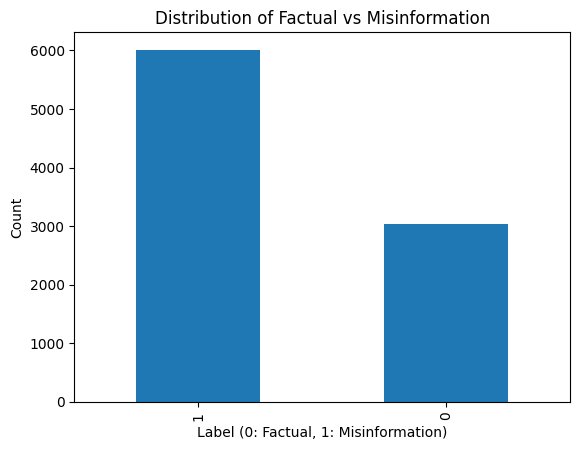

In [60]:
# Count occurrences of each label
label_counts = df_climate_inference['predicted_label'].value_counts()

print("Distribution of Factual vs Misinformation:")
print(label_counts)

# If you want to visualise this distribution:
import matplotlib.pyplot as plt

label_counts.plot(kind='bar')
plt.title('Distribution of Factual vs Misinformation')
plt.xlabel('Label (0: Factual, 1: Misinformation)')
plt.ylabel('Count')
plt.show()

In [61]:
# Extract 10 examples of factual (label == 0)
factual_examples = df_climate_inference[df_climate_inference['predicted_label'] == 0].head(10)

# Extract 10 examples of misinformation (label == 1)
misinfo_examples = df_climate_inference[df_climate_inference['predicted_label'] == 1].head(10)

print("10 Examples of Factual (predicted_label 0):")
print(factual_examples)

print("\n10 Examples of Misinformation (predicted_label 1):")
print(misinfo_examples)


10 Examples of Factual (predicted_label 0):
                                                 text  predicted_label
1   Climate change doesn’t cause volcanic eruption...                0
3   North America has experienced an average winte...                0
5   HELLO AMERICA,\n\nWho would have ever thought ...                0
6   fucking hell this weather makes me really fuck...                0
11  Ronald Reagan (1989): "Because changes in the ...                0
12  #Geopolitics could have a material impact on #...                0
13  The climate crisis is front page news in South...                0
17  ... don't be the person that only thinks about...                0
18  Is this guy real? BBC News - Climate change: W...                0
22  Toronto Ontario; the city that thought snow pl...                0

10 Examples of Misinformation (predicted_label 1):
                                                 text  predicted_label
0   The only solution I’ve ever heard the Left pro..

In [ ]:
# pipeline for RNNs etc (need to rework / a lot not needed)
'''
vocab_idx = vocab_mapping(tokenized_text=climate_tokenised) # is this correct?? ithink not
 
climate_dl = DataLoader(
    dataset=list(zip(climate_tokenised,climate_tokenised["label"])), # THIS SHOULD BE BLANK...
    batch_size=32, 
    shuffle=False, 
    collate_fn=collate_fn)

EMBEDDINGS_FILE_PATH_CLIMATE = "./cache/mapped_pretrained_embeddings_climate.pkl"

if os.path.exists(EMBEDDINGS_FILE_PATH_CLIMATE):
    with open(EMBEDDINGS_FILE_PATH_CLIMATE, 'rb') as f:
        embedding_tensor_climate = pickle.load(f)
    print(f"Emebddings pre-exists: loaded embeddings from {EMBEDDINGS_FILE_PATH_CLIMATE}. Shape: {embedding_tensor_climate.shape}")
else:
    print("Embeddings do not pre-exist: mapping pretrained fasttext embeddings to vocabulary indices")

    mapped_pretrained_embeddings_climate = embedding_mapping_fasttext(vocabulary=vocab_idx,
                                                              pre_trained_embeddings=ft)
    embedding_tensor = torch.FloatTensor(mapped_pretrained_embeddings_climate)

    # Save embeddings
    with open(EMBEDDINGS_FILE_PATH_CLIMATE, 'wb') as f:
        pickle.dump(embedding_tensor, f)
    print(f"Saved embeddings to {EMBEDDINGS_FILE_PATH_CLIMATE}. Shape: {embedding_tensor_climate.shape}")
'''